<a href="https://colab.research.google.com/github/cayang17/ds3001_GroupR/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obesity Prediction: Machine Learning Models
## DS 3001 - Milestone 3: Results

This notebook implements multiple classification models:
- k-Nearest Neighbors (kNN) Classification
- Decision Tree Classification
- Logistic Regression Classification
- Principal Component Analysis (PCA)
- k-Means Clustering

**Authors**: Caleb Kim, Daniel Song, Christina Yang  
**Date**: November 2025

## 1. Setup and Data Loading

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, silhouette_score
)

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load the cleaned dataset
# UPDATE THIS PATH for your environment (Google Colab, local, etc.)
df = pd.read_csv('cleaned_obesity_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nObesity rate: {df['OBESE'].mean():.2%}")
print(f"Sample size: {len(df):,} individuals")
print(f"Number of states: {df['State'].nunique()}")

Dataset shape: (130518, 39)

Columns: ['State', 'BMI', 'OBESE', 'AGE', 'MALE', 'RACE_WHITE', 'RACE_BLACK', 'RACE_HISPANIC', 'INCOME', 'EXERCISE', 'PHYSICAL_ACTIVITY_MIN', 'EVER_SMOKER', 'CURRENT_SMOKER', 'ALCOHOL_DAYS', 'BINGE_DRINKING', 'FRUIT_PER_DAY', 'VEG_PER_DAY', 'GROC14', 'GROCPTH14', 'SUPERC14', 'SUPERCPTH14', 'CONVS14', 'CONVSPTH14', 'SPECS14', 'SPECSPTH14', 'SNAPS16', 'SNAPSPTH16', 'FFR14', 'FFRPTH14', 'FSR14', 'FSRPTH14', 'PC_FFRSALES12', 'PC_FSRSALES12', 'PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_CHILD15', 'PCT_LACCESS_SENIORS15', 'PCT_LACCESS_SNAP15', 'State_Name']

Obesity rate: 30.02%
Sample size: 130,518 individuals
Number of states: 17


## 2. Data Preparation for Modeling

In [ ]:
# Separate features and target
# Exclude: State, State_Name (categorical identifiers), BMI (directly determines obesity), OBESE (target)
exclude_cols = ['State', 'State_Name', 'BMI', 'OBESE']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].copy()
y = df['OBESE'].copy()

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nFeatures used ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Double-check all columns are numeric
non_numeric = X.select_dtypes(include=['object']).columns.tolist()
if non_numeric:
    print(f"\n⚠️ WARNING: Non-numeric columns found: {non_numeric}")
    print("Removing them...")
    X = X.drop(non_numeric, axis=1)
    feature_cols = [col for col in feature_cols if col not in non_numeric]
    print(f"New feature count: {len(feature_cols)}")
else:
    print("\n✓ All columns are numeric")

Feature matrix X shape: (130518, 35)
Target vector y shape: (130518,)

Features used (35):
 1. AGE
 2. MALE
 3. RACE_WHITE
 4. RACE_BLACK
 5. RACE_HISPANIC
 6. INCOME
 7. EXERCISE
 8. PHYSICAL_ACTIVITY_MIN
 9. EVER_SMOKER
10. CURRENT_SMOKER
11. ALCOHOL_DAYS
12. BINGE_DRINKING
13. FRUIT_PER_DAY
14. VEG_PER_DAY
15. GROC14
16. GROCPTH14
17. SUPERC14
18. SUPERCPTH14
19. CONVS14
20. CONVSPTH14
21. SPECS14
22. SPECSPTH14
23. SNAPS16
24. SNAPSPTH16
25. FFR14
26. FFRPTH14
27. FSR14
28. FSRPTH14
29. PC_FFRSALES12
30. PC_FSRSALES12
31. PCT_LACCESS_POP15
32. PCT_LACCESS_LOWI15
33. PCT_LACCESS_CHILD15
34. PCT_LACCESS_SENIORS15
35. PCT_LACCESS_SNAP15

✓ All columns are numeric


In [ ]:
# Check for any remaining missing values
missing = X.isnull().sum()
if missing.sum() > 0:
    print("WARNING: Missing values detected:")
    print(missing[missing > 0])
else:
    print("✓ No missing values in feature matrix")

# Verify no infinite values - check each float column individually
inf_cols = []
for col in X.columns:
    if X[col].dtype in ['float64', 'float32']:
        if np.isinf(X[col]).any():
            inf_cols.append(col)

if inf_cols:
    print(f"WARNING: Infinite values detected in columns: {inf_cols}")
else:
    print("✓ No infinite values in feature matrix")

✓ No missing values in feature matrix
✓ No infinite values in feature matrix


In [ ]:
# Train-test split (80-20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {len(X_train):,} ({len(X_train)/len(X):.1%})")
print(f"Test set size: {len(X_test):,} ({len(X_test)/len(X):.1%})")
print(f"\nObesity rate in training set: {y_train.mean():.2%}")
print(f"Obesity rate in test set: {y_test.mean():.2%}")

Training set size: 104,414 (80.0%)
Test set size: 26,104 (20.0%)

Obesity rate in training set: 30.02%
Obesity rate in test set: 30.02%


In [ ]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("Features standardized successfully!")
print(f"\nExample - AGE before scaling:")
print(f"  Mean: {X_train['AGE'].mean():.2f}, Std: {X_train['AGE'].std():.2f}")
print(f"\nAGE after scaling:")
print(f"  Mean: {X_train_scaled['AGE'].mean():.2f}, Std: {X_train_scaled['AGE'].std():.2f}")

Features standardized successfully!

Example - AGE before scaling:
  Mean: 55.58, Std: 17.36

AGE after scaling:
  Mean: -0.00, Std: 1.00


## 3. k-Nearest Neighbors (kNN) - Baseline Model

In [ ]:
# For faster execution, we'll use a smaller parameter grid
# (The full grid search can take 30+ minutes)
param_grid_knn = {
    'n_neighbors': [5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running Grid Search for kNN...")
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search_knn.best_params_}")
print(f"Best CV accuracy: {grid_search_knn.best_score_:.4f}")

# Test set evaluation
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
y_pred_proba_knn = best_knn.predict_proba(X_test_scaled)[:, 1]

knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_auc = roc_auc_score(y_test, y_pred_proba_knn)

print(f"\nTest Accuracy: {knn_accuracy:.4f}")
print(f"ROC AUC: {knn_auc:.4f}")

Running Grid Search for kNN...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
Best CV accuracy: 0.6891

Test Accuracy: 0.6894
ROC AUC: 0.6139


## 4. Decision Tree

In [ ]:
param_grid_tree = {
    'max_depth': [5, 7, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

tree = DecisionTreeClassifier(random_state=42)

print("Running Grid Search for Decision Tree...")
grid_search_tree = GridSearchCV(tree, param_grid_tree, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_tree.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search_tree.best_params_}")
print(f"Best CV accuracy: {grid_search_tree.best_score_:.4f}")

# Test set evaluation
best_tree = grid_search_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test_scaled)
y_pred_proba_tree = best_tree.predict_proba(X_test_scaled)[:, 1]

tree_accuracy = accuracy_score(y_test, y_pred_tree)
tree_auc = roc_auc_score(y_test, y_pred_proba_tree)

print(f"\nTest Accuracy: {tree_accuracy:.4f}")
print(f"ROC AUC: {tree_auc:.4f}")

Running Grid Search for Decision Tree...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV accuracy: 0.7010

Test Accuracy: 0.6999
ROC AUC: 0.6346


## 5. Logistic Regression

In [ ]:
# Parameter grid for Logistic Regression
param_grid_log = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced'],
    'max_iter': [300, 500]
}

log_reg = LogisticRegression()

print("Running Grid Search for Logistic Regression...")
grid_search_log = GridSearchCV(
    log_reg,
    param_grid_log,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_log.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search_log.best_params_}")
print(f"Best CV accuracy: {grid_search_log.best_score_:.4f}")

# Test set evaluation
best_log = grid_search_log.best_estimator_
y_pred_log = best_log.predict(X_test_scaled)
y_pred_proba_log = best_log.predict_proba(X_test_scaled)[:, 1]

log_accuracy = accuracy_score(y_test, y_pred_log)
log_auc = roc_auc_score(y_test, y_pred_proba_log)

print(f"\nTest Accuracy: {log_accuracy:.4f}")
print(f"ROC AUC: {log_auc:.4f}")


Running Grid Search for Logistic Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best parameters: {'C': 0.01, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV accuracy: 0.6994

Test Accuracy: 0.6993
ROC AUC: 0.6152


## 6. Model Comparison

In [ ]:
# Compare all three models
comparison_df = pd.DataFrame({
    'Model': ['k-Nearest Neighbors', 'Decision Tree', 'Logistic Regression'],
    'Test Accuracy': [knn_accuracy, tree_accuracy, log_accuracy],
    'ROC AUC': [knn_auc, tree_auc, log_auc],
    'CV Accuracy': [
        grid_search_knn.best_score_,
        grid_search_tree.best_score_,
        grid_search_log.best_score_
    ]
})

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print(f"\nBest Model (by Test Accuracy): {comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'Model']}")
print(f"Best Model (by ROC AUC): {comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']}")

MODEL COMPARISON
              Model  Test Accuracy  ROC AUC  CV Accuracy
k-Nearest Neighbors       0.689358 0.613880     0.689084
      Decision Tree       0.699893 0.634613     0.700950
Logistic Regression       0.699318 0.615165     0.699379

Best Model (by Test Accuracy): Decision Tree
Best Model (by ROC AUC): Decision Tree


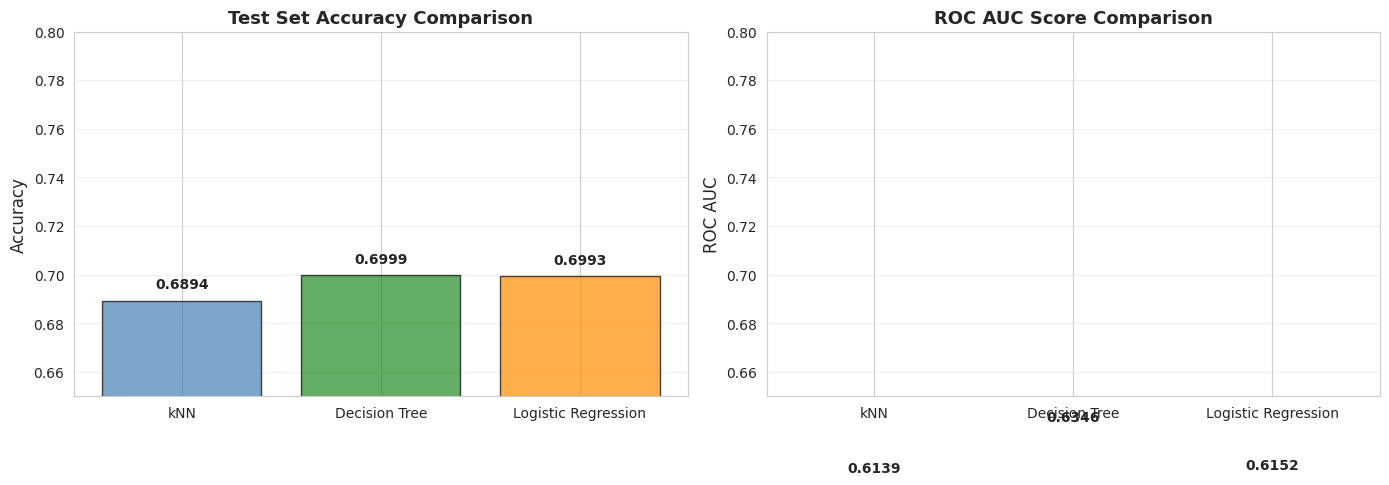

Plot saved: all_models_comparison.png


In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['kNN', 'Decision Tree', 'Logistic Regression']
accuracies = [knn_accuracy, tree_accuracy, log_accuracy]
aucs = [knn_auc, tree_auc, log_auc]
colors = ['steelblue', 'forestgreen', 'darkorange']

# Plot 1: Accuracy
axes[0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Test Set Accuracy Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0.65, 0.80])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# Plot 2: AUC
axes[1].bar(models, aucs, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('ROC AUC', fontsize=12)
axes[1].set_title('ROC AUC Score Comparison', fontsize=13, fontweight='bold')
axes[1].set_ylim([0.65, 0.80])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(aucs):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: all_models_comparison.png")

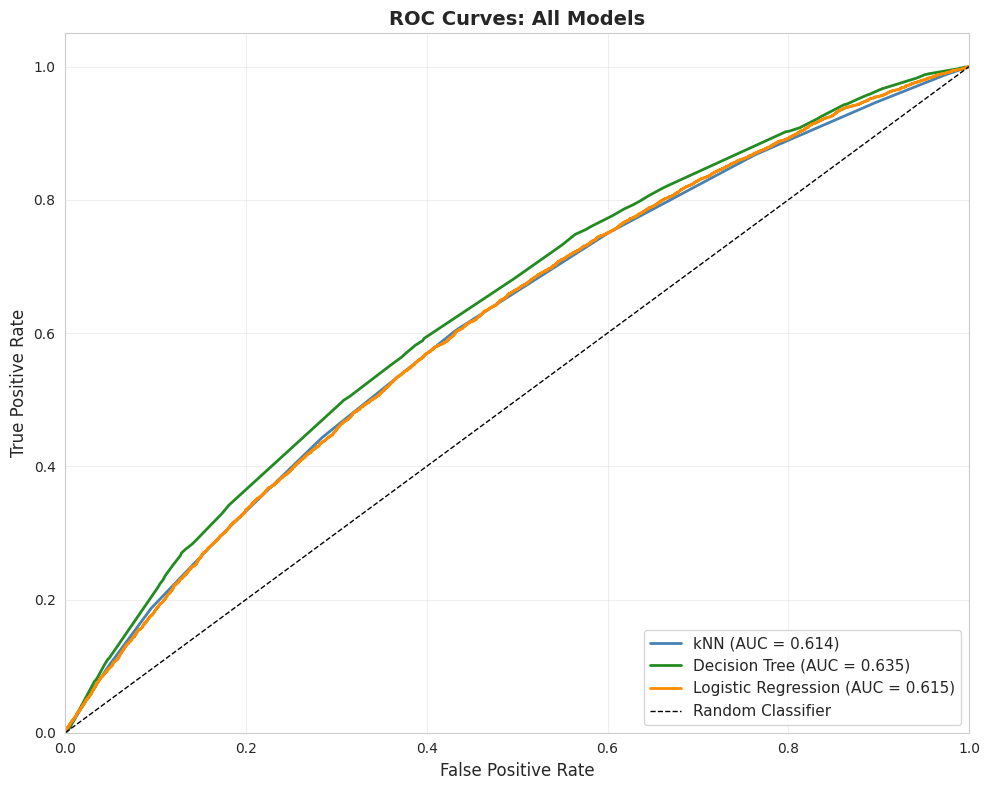

Plot saved: roc_curves_all_models.png


In [ ]:
# ROC Curves for all models
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_proba_tree)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_log)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label=f'kNN (AUC = {knn_auc:.3f})', color='steelblue')
plt.plot(fpr_tree, tpr_tree, linewidth=2, label=f'Decision Tree (AUC = {tree_auc:.3f})', color='forestgreen')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Logistic Regression (AUC = {log_auc:.3f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: roc_curves_all_models.png")

## 7. Feature Importance Analysis (Decision Tree vs Logistic Regression)

In [ ]:
# Get feature importances from tree and logistic regression (use coefficients)
log_reg_coef = best_log.coef_[0]  # 1D array

feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Decision_Tree': best_tree.feature_importances_,
    'Logistic_Regression': log_reg_coef
})

# Sort by absolute coefficient magnitude for better interpretation
feature_importance_df['LogReg_Abs'] = feature_importance_df['Logistic_Regression'].abs()

# Sort by logistic regression importance
feature_importance_df = feature_importance_df.sort_values('LogReg_Abs', ascending=False)

print("\nTop 15 Most Important Features (Logistic Regression):")
print(feature_importance_df[['Feature', 'Logistic_Regression', 'Decision_Tree']].head(15).to_string(index=False))


Top 15 Most Important Features (Logistic Regression):
              Feature  Logistic_Regression  Decision_Tree
    PCT_LACCESS_POP15            -0.258901       0.002454
             EXERCISE            -0.213388       0.209775
           RACE_BLACK             0.171801       0.067314
            GROCPTH14             0.160959       0.003282
             FSRPTH14            -0.153711       0.000280
       CURRENT_SMOKER            -0.138141       0.065307
PCT_LACCESS_SENIORS15             0.137836       0.000840
PHYSICAL_ACTIVITY_MIN            -0.116052       0.030158
             FFRPTH14            -0.107536       0.011363
               INCOME            -0.106823       0.047328
         ALCOHOL_DAYS            -0.086557       0.049186
        FRUIT_PER_DAY            -0.083690       0.016845
        RACE_HISPANIC             0.078035       0.002920
              CONVS14            -0.072036       0.000000
          EVER_SMOKER             0.068407       0.002831


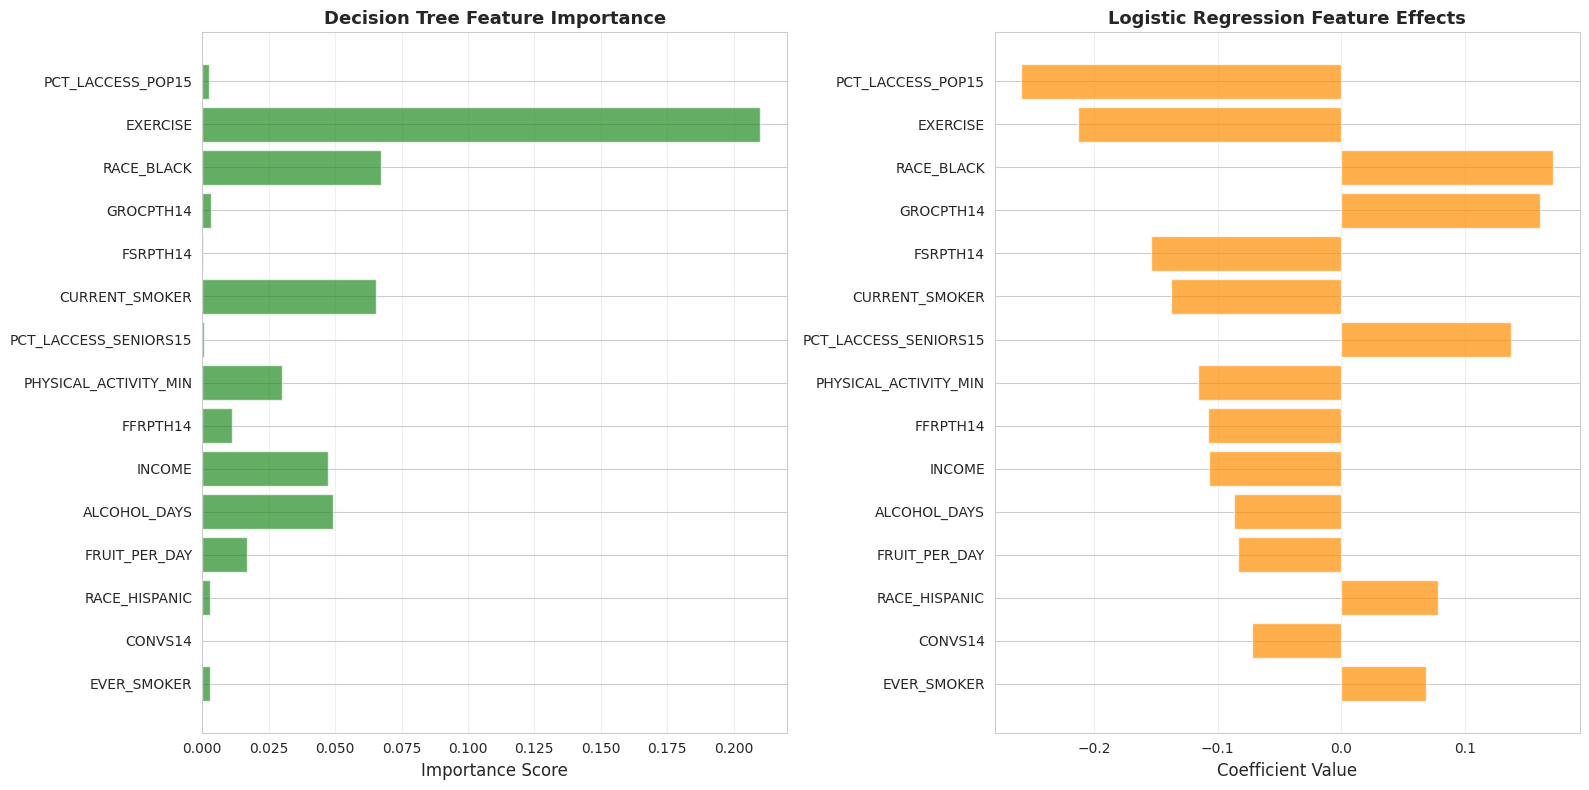

Plot saved: feature_importance_comparison.png


In [ ]:
# Visualize feature importance comparison
top_15 = feature_importance_df.head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Decision Tree importance
axes[0].barh(range(len(top_15)), top_15['Decision_Tree'], color='forestgreen', alpha=0.7)
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15['Feature'])
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('Decision Tree Feature Importance', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Logistic Regression coefficients
axes[1].barh(range(len(top_15)), top_15['Logistic_Regression'], color='darkorange', alpha=0.7)
axes[1].set_yticks(range(len(top_15)))
axes[1].set_yticklabels(top_15['Feature'])
axes[1].set_xlabel('Coefficient Value', fontsize=12)
axes[1].set_title('Logistic Regression Feature Effects', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: feature_importance_comparison.png")


## 8. Confusion Matrices for All Models

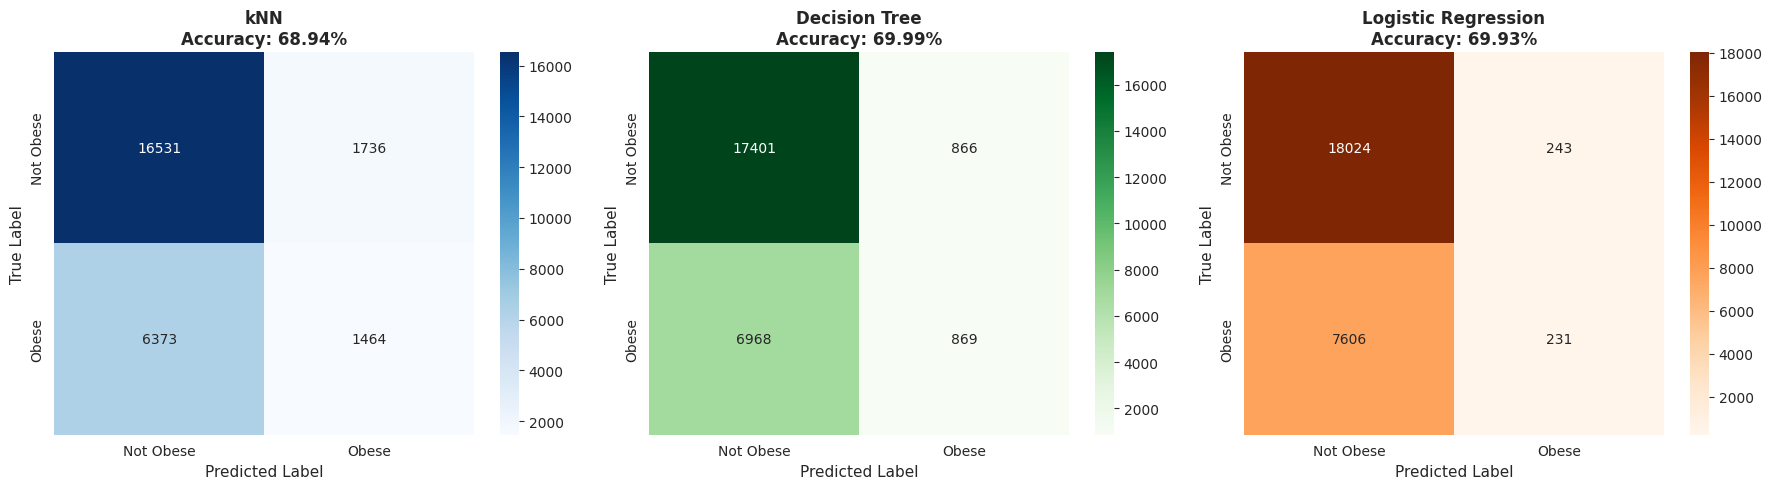

Plot saved: confusion_matrices_all.png


In [ ]:
# Create confusion matrices for all models
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_rf = confusion_matrix(y_test, y_pred_log)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# kNN
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Obese', 'Obese'],
            yticklabels=['Not Obese', 'Obese'])
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_title(f'kNN\nAccuracy: {knn_accuracy:.2%}', fontsize=12, fontweight='bold')

# Decision Tree
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Not Obese', 'Obese'],
            yticklabels=['Not Obese', 'Obese'])
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_title(f'Decision Tree\nAccuracy: {tree_accuracy:.2%}', fontsize=12, fontweight='bold')

# Logistic Regression
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=['Not Obese', 'Obese'],
            yticklabels=['Not Obese', 'Obese'])
axes[2].set_ylabel('True Label', fontsize=11)
axes[2].set_xlabel('Predicted Label', fontsize=11)
axes[2].set_title(f'Logistic Regression\nAccuracy: {log_accuracy:.2%}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_all.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: confusion_matrices_all.png")

## 9. Classification Reports

In [ ]:
print("="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

print("\nk-NEAREST NEIGHBORS:")
print("-" * 80)
print(classification_report(y_test, y_pred_knn, target_names=['Not Obese', 'Obese']))

print("\nDECISION TREE:")
print("-" * 80)
print(classification_report(y_test, y_pred_tree, target_names=['Not Obese', 'Obese']))

print("\nLOSISTIC REGRESSION:")
print("-" * 80)
print(classification_report(y_test, y_pred_log, target_names=['Not Obese', 'Obese']))

DETAILED CLASSIFICATION REPORTS

k-NEAREST NEIGHBORS:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

   Not Obese       0.72      0.90      0.80     18267
       Obese       0.46      0.19      0.27      7837

    accuracy                           0.69     26104
   macro avg       0.59      0.55      0.53     26104
weighted avg       0.64      0.69      0.64     26104


DECISION TREE:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

   Not Obese       0.71      0.95      0.82     18267
       Obese       0.50      0.11      0.18      7837

    accuracy                           0.70     26104
   macro avg       0.61      0.53      0.50     26104
weighted avg       0.65      0.70      0.63     26104


LOSISTIC REGRESSION:
--------------------------------------------------------------------------------
           

## 10. Export Results

In [ ]:
# Create comprehensive results summary
results_summary = pd.DataFrame({
    'Model': ['k-Nearest Neighbors', 'Decision Tree', 'Logistic Regression'],
    'Test_Accuracy': [f"{knn_accuracy:.4f}", f"{tree_accuracy:.4f}", f"{log_accuracy:.4f}"],
    'ROC_AUC': [f"{knn_auc:.4f}", f"{tree_auc:.4f}", f"{log_auc:.4f}"],
    'CV_Accuracy': [
        f"{grid_search_knn.best_score_:.4f}",
        f"{grid_search_tree.best_score_:.4f}",
        f"{grid_search_log.best_score_:.4f}"
    ],
    'Best_Parameters': [
        str(grid_search_knn.best_params_),
        str(grid_search_tree.best_params_),
        str(grid_search_log.best_params_)
    ]
})

# Save results
results_summary.to_csv('model_results_with_log_reg.csv', index=False)
feature_importance_df.to_csv('feature_importance_all.csv', index=False)

print("Results exported to CSV files:")
print("  - model_results_with_log_reg.csv")
print("  - feature_importance_all.csv")

print("\nFinal Results Summary:")
print(results_summary.to_string(index=False))


Results exported to CSV files:
  - model_results_with_log_reg.csv
  - feature_importance_all.csv

Final Results Summary:
              Model Test_Accuracy ROC_AUC CV_Accuracy                                                                            Best_Parameters
k-Nearest Neighbors        0.6894  0.6139      0.6891                           {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
      Decision Tree        0.6999  0.6346      0.7010       {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Logistic Regression        0.6993  0.6152      0.6994 {'C': 0.01, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}
